In [1]:
%matplotlib inline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import numpy as np
import scipy.io as io
import matplotlib.pyplot as plt

In [2]:
plt.style.use('fivethirtyeight')

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['lines.linewidth'] = 2

colors = ['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c', '#137e6d', '#be0119', '#3b638c', '#af6f09',
         '#c79fef', '#80f9ad']

In [3]:
import urllib.request

filepath = "../dataset/"
url = "https://tvml.github.io/ml1920/dataset/"

def get_file(filename,local):
    if local:
        return filepath+filename
    else:
        urllib.request.urlretrieve (url+filename, filename)
        return filename

Legge il dataset

In [4]:
data = io.loadmat(get_file("XwindowsDocData.mat",local=0))

xtrain = data['xtrain']
ytrain = data['ytrain']

ndocs = xtrain.shape[0] 
nterms = xtrain.shape[1]
classes = np.unique(ytrain)
nclasses = classes.shape[0]

In [5]:
nterms

600

In [6]:
data['vocab']

array([[array(['straight'], dtype='<U8')],
       [array(['magazines'], dtype='<U9')],
       [array(['issues'], dtype='<U6')],
       [array(['ray'], dtype='<U3')],
       [array(['enabled'], dtype='<U7')],
       [array(['head'], dtype='<U4')],
       [array(['improved'], dtype='<U8')],
       [array(['thread'], dtype='<U6')],
       [array(['libs'], dtype='<U4')],
       [array(['working'], dtype='<U7')],
       [array(['presented'], dtype='<U9')],
       [array(['exactly'], dtype='<U7')],
       [array(['downloaded'], dtype='<U10')],
       [array(['hoping'], dtype='<U6')],
       [array(['described'], dtype='<U9')],
       [array(['difficult'], dtype='<U9')],
       [array(['wclriscspsmotcom'], dtype='<U16')],
       [array(['remember'], dtype='<U8')],
       [array(['company'], dtype='<U7')],
       [array(['icons'], dtype='<U5')],
       [array(['hundred'], dtype='<U7')],
       [array(['knowing'], dtype='<U7')],
       [array(['apart'], dtype='<U5')],
       [array(['found'], d

In [7]:
xtrain.shape

(900, 600)

In [8]:
l = np.array([xtrain[4,i] for i in range(xtrain.shape[1])]).squeeze()
print('{0:3.0f} termini diversi nel documento, {1:5.3f}% di tutto il vocabolario'.format(l.sum(), 
                l.sum()/xtrain.shape[1]*100))
print(np.argwhere(l == 1).reshape(1,-1)[0])

  8 termini diversi nel documento, 1.333% di tutto il vocabolario
[ 85 106 152 203 388 465 516 542]


Crea un classificatore Naive-Bayes ed effettua il learning sul dataset

In [9]:
clf = MultinomialNB(alpha=1.0e-9)
clf.fit(xtrain, ytrain.ravel())

MultinomialNB(alpha=1e-09, class_prior=None, fit_prior=True)

Deriva probabilità a priori delle classi $p(C_i)$

In [10]:
pclass=np.exp(clf.class_log_prior_)
pclass

array([0.5, 0.5])

Deriva probabilità a posteriori delle feature (termini) $p(t_j|C_i)$

In [11]:
pf=np.exp(clf.feature_log_prob_)
pf.shape

(2, 600)

In [12]:
pf[0,:20]

array([1.67448091e-04, 1.67448091e-13, 3.34896182e-04, 1.67448091e-04,
       3.34896182e-04, 1.67448091e-04, 1.67448091e-13, 6.69792364e-04,
       8.37240456e-04, 4.52109846e-03, 1.67448091e-04, 2.34427328e-03,
       3.34896182e-04, 1.67448091e-04, 3.34896182e-04, 5.02344273e-04,
       3.34896182e-04, 2.34427328e-03, 3.01406564e-03, 1.67448091e-03])

Deriva probabilità a priori delle feature $p(t_j)=p(t_j|C_1)p(C_1)+p(t_j|C_2)p(C_2)$

In [13]:
pfeature=np.array([pf[0,i]*pclass[0]+pf[1,i]*pclass[1] for i in range(pf.shape[1])])
pfeature.shape

(600,)

In [14]:
pfeature[:20]

array([3.88230745e-04, 3.04506699e-04, 4.71954790e-04, 8.37240457e-05,
       2.43574766e-04, 6.16610769e-04, 7.61266749e-05, 9.43909581e-04,
       4.18620228e-04, 4.69660282e-03, 1.59850720e-04, 2.00953006e-03,
       6.24208140e-04, 4.64357420e-04, 3.95828116e-04, 4.03425486e-04,
       3.19701441e-04, 2.69467013e-03, 2.87731297e-03, 1.37012718e-03])

In [15]:
ppost = np.zeros([pf.shape[0],pf.shape[1]])
for i in range(pf.shape[0]):
    for j in range(pf.shape[1]):
        ppost[i,j] = pf[i,j]*pclass[i]/pfeature[j]

In [16]:
ppost[0,:20]

array([2.15655372e-01, 2.74949765e-10, 3.54796889e-01, 9.99999999e-01,
       6.87460749e-01, 1.35781030e-01, 1.09979906e-09, 3.54796889e-01,
       1.00000000e+00, 4.81315818e-01, 5.23763955e-01, 5.83288929e-01,
       2.68256821e-01, 1.80300868e-01, 4.23032333e-01, 6.22598584e-01,
       5.23763955e-01, 4.34983348e-01, 5.23763955e-01, 6.11067694e-01])

Plot del modello di linguaggio risultante per le due classi

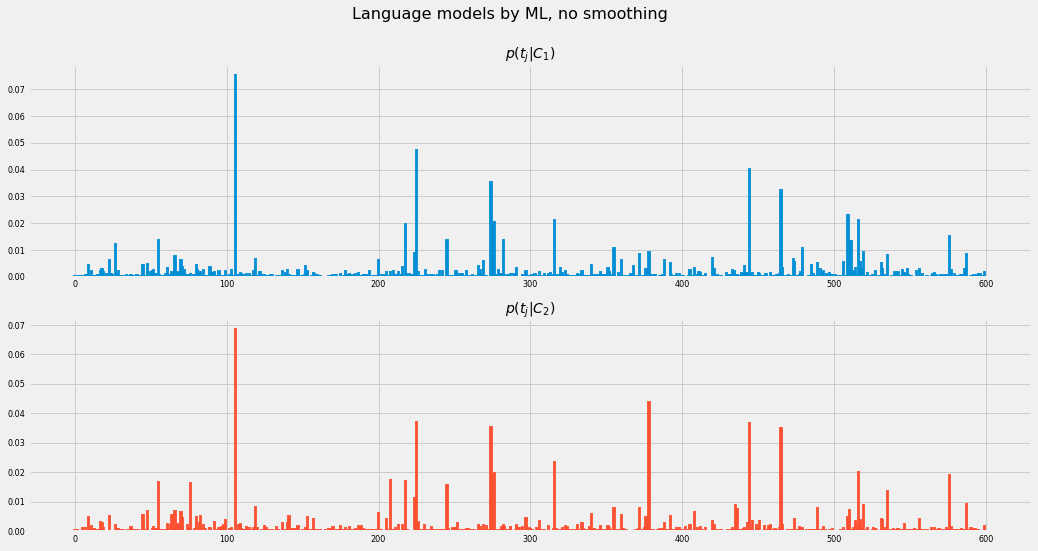

In [17]:
fig=plt.figure(figsize=(16,8))
for i,c in enumerate(classes):
    ax=plt.subplot(nclasses,1,i+1)
    ax.bar(range(clf.feature_count_.shape[1]), pf[i,:],  facecolor=colors[i], alpha=0.9, edgecolor=colors[i], lw=2)
    plt.title('$p(t_j|C_{0:1d})$'.format(c), fontsize=14)
plt.suptitle('Language models by ML, no smoothing ', fontsize=16)
plt.show()

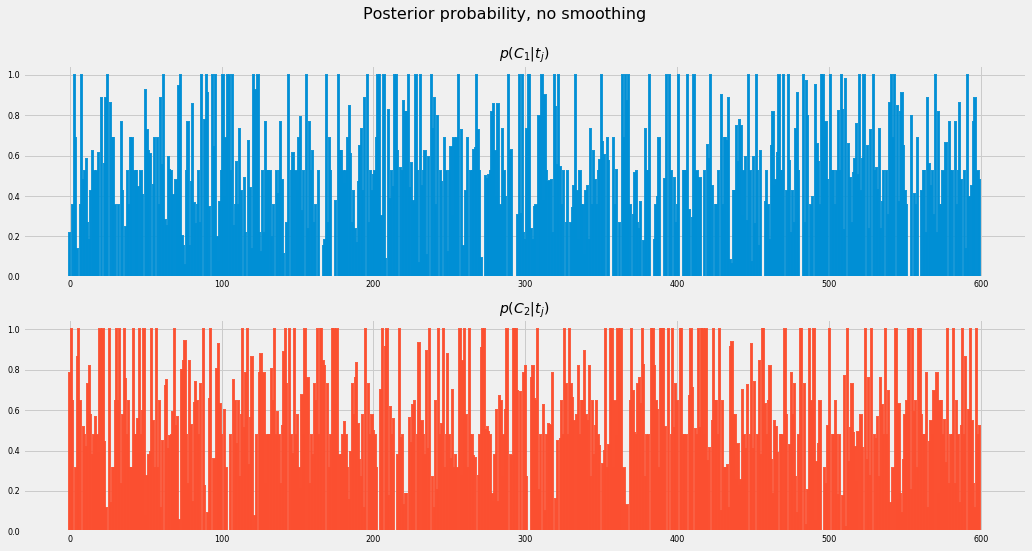

In [18]:
fig=plt.figure(figsize=(16,8))
for i,c in enumerate(classes):
    ax=plt.subplot(nclasses,1,i+1)
    ax.bar(range(clf.feature_count_.shape[1]), ppost[i,:],  facecolor=colors[i], alpha=0.9, edgecolor=colors[i], lw=2)
    plt.title('$p(C_{0:1d}|t_j)$'.format(c), fontsize=14)
plt.suptitle('Posterior probability, no smoothing ', fontsize=16)
plt.show()

Applicazione del classificatore al training set e derivazione della accuracy

In [19]:
preds = clf.predict(xtrain)
print('Accuracy = {0:8.7f}'.format(accuracy_score(ytrain, preds)))

Accuracy = 0.9211111


Istanza classificatore Naive-Bayes con Dirichlet smoothing simmetrico, con iperparametro $\alpha$ ed effettua il learning sul dataset

In [20]:
alpha = 100
clf1 = MultinomialNB(alpha)
clf1.fit(xtrain, ytrain.ravel())

MultinomialNB(alpha=100, class_prior=None, fit_prior=True)

Deriva probabilità a posteriori delle feature (termini) $p(t_j|C_i)$

In [21]:
pf1=np.exp(clf1.feature_log_prob_)

Plot del modello di linguaggio risultante per le due classi

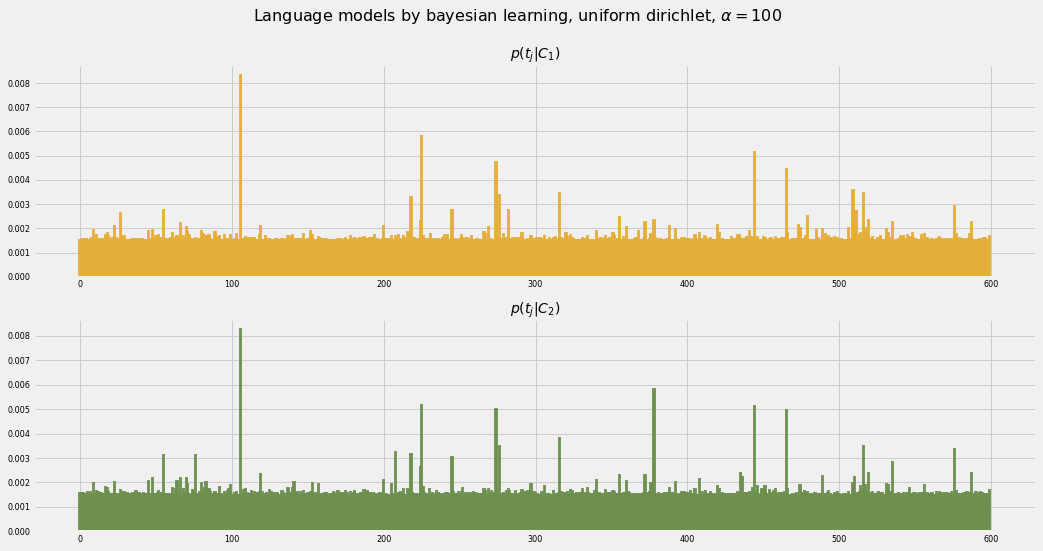

In [22]:
fig=plt.figure(figsize=(16,8))
for i,c in enumerate(classes):
    ax=plt.subplot(nclasses,1,i+1)
    ax.bar(range(clf1.feature_count_.shape[1]), pf1[i,:],  facecolor=colors[i+2], alpha=0.9, edgecolor=colors[i+2], lw=2)
    plt.title('$p(t_j|C_{0:1d})$'.format(c), fontsize=14)
plt.suptitle(r"Language models by bayesian learning, uniform dirichlet, $\alpha= {0:2d}$".format(alpha), fontsize=16)
plt.show()

Applicazione del classificatore al training set e derivazione della accuracy

In [23]:
preds1 = clf1.predict(xtrain)
print('Accuracy = {0:8.7f}'.format(accuracy_score(ytrain, preds1)))

Accuracy = 0.8533333


Definizione della funzione che calcola la mutua informazione di una feature con le due classi

In [24]:
def mutual_information(feature):
    s = 0
    for cl in [0,1]:
        s += pf[cl, feature]*pclass[cl]*np.log2(pf[cl, feature]/pfeature[feature])
    return s

Calcolo del valore della mutua informazione per ogni feature

In [25]:
mi = np.array([mutual_information(f) for f in range(pf.shape[1])])

Ordinamento crescente delle feature rispetto alla mutua informazione

In [26]:
ordered_features = np.argsort(mi)

Plot della mutua informazione delle feature

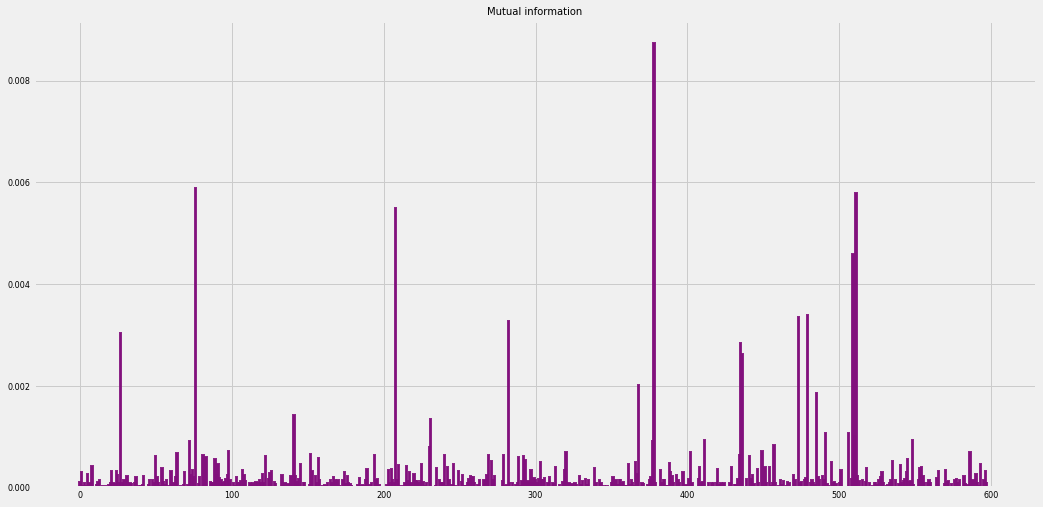

In [27]:
fig=plt.figure(figsize=(16,8))
plt.bar(range(clf1.feature_count_.shape[1]), mi,  facecolor=colors[5], alpha=0.9, edgecolor=colors[5], lw=2)
plt.title(r"Mutual information")
plt.show()

Seleziona le feature più informative e riduci il training set considerando solo quelle

In [28]:
k = 15
x_red = xtrain[:, ordered_features[-k:]]

Plot della mutua informazione delle feature selezionate

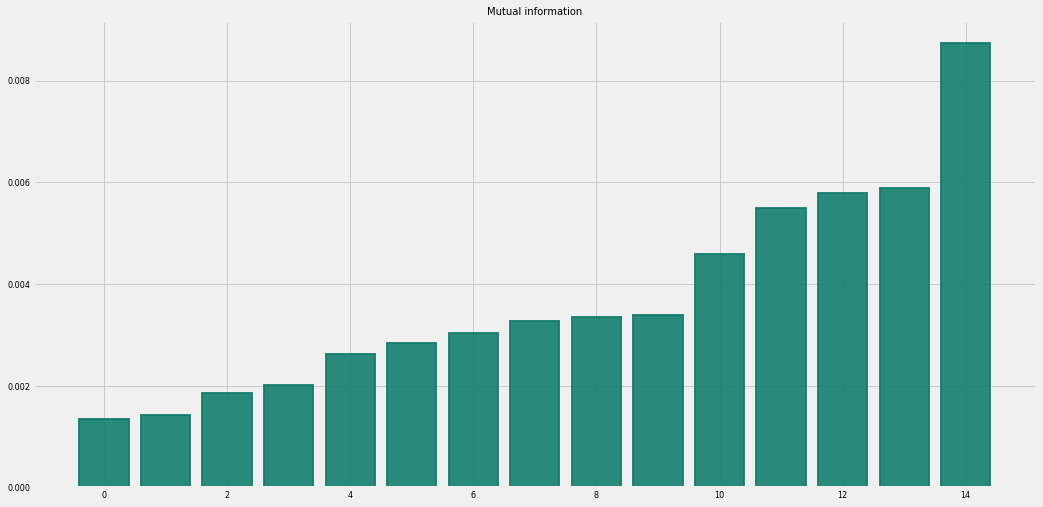

In [29]:
fig=plt.figure(figsize=(16,8))
plt.bar(range(k), mi[ordered_features[-k:]],  facecolor=colors[6], alpha=0.9, edgecolor=colors[6], lw=2)
plt.title(r"Mutual information")
plt.show()

Crea un nuovo classificatore Naive Bayes ed effettua l'apprendimento sul training set ridotto 

In [30]:
clf2 = MultinomialNB(alpha=1.0e-9)
clf2.fit(x_red, ytrain.ravel())

MultinomialNB(alpha=1e-09, class_prior=None, fit_prior=True)

Applicazione del classificatore al training set ridotto e derivazione della accuracy

In [31]:
preds2 = clf2.predict(x_red)
print('Accuracy = {0:8.7f}'.format(accuracy_score(ytrain, preds2)))

Accuracy = 0.8777778
